<a href="https://colab.research.google.com/github/psukphranee/Machine-Learning-Projects/blob/master/Python%20SKLearn/Classification/multilabel_multioutput_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilabel and Multioutput Classification

## Pull Data

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

X = mnist.data
y = mnist.target

In [2]:
import numpy as np

y = y.astype(np.uint8)
X_train, y_train, X_test, y_test = X[:60000,:], y[:60000], X[60000:,:], y[60000:]


## Multilabel Classification

We'll train a K-nearest Neighbors algorithm on our training set with two labels: whether it's >= 7 and whether or not it's odd. The algorithm KNN model natively supports multiple labels, but not all models do.

In [3]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

In [4]:
#filter labels, one for odd and the other \geq 7
y_train_geq_7 = y_train >= 7
y_train_odd = (y_train % 2) == 1

y_train_multi = np.c_[y_train_geq_7, y_train_odd]

In [5]:
knn_clf.fit(X_train, y_train_multi)

KNeighborsClassifier()

Select a random sample. Inspect it and see how what our multilabel model predicts.

In [6]:
#select a random sample and see what our model predicts
rand_index = (np.random.randint(0, 60000))
X_sample = X_train[rand_index]
y_sample = y_train[rand_index]

In [7]:
import matplotlib.pyplot as plt

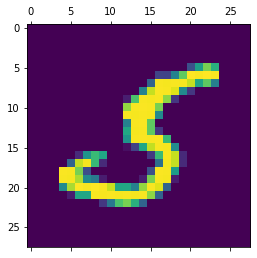

5

In [8]:
plt.matshow(X_sample.reshape(28,28))
plt.show()
display(y_sample)

In [9]:
knn_clf.predict([X_sample])

array([[False,  True]])

In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train_multi, cv=3)
f1_score(y_train_multi, y_train_knn_pred, average='macro')


0.976410265560605